In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import scipy.signal as ss
import h5py
import os

from analysis import plot

output_name = 'output_drifting'
model_dir = os.path.join('..', 'V1_bio')
output_dir = os.path.join('..', 'V1_bio_outputs', output_name)
data_dir = os.path.join('.', 'data')
trial_dir = os.path.join(data_dir, output_name)

In [2]:
lfp_data = h5py.File(os.path.join(output_dir, 'ecp.h5'))

lfps = xr.DataArray(
    lfp_data['ecp']['data'][()].T,
    coords = dict(
        channel_id = lfp_data['ecp']['channel_id'][()]
        time = np.arange(*lfp_data['ecp']['time']),
    ),
    attrs = dict(
        fs = 1000 / lfp_data['ecp']['time'][2]
    )
)
display(lfps)

SyntaxError: invalid syntax (4217029471.py, line 7)

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 4 - 200 Hz                        
                                 Frequency Resolution is 2.00 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -4.5366, -5.3633, 1.4008                                     
                                                                                                  
                                       6 peaks were found:                                        
          

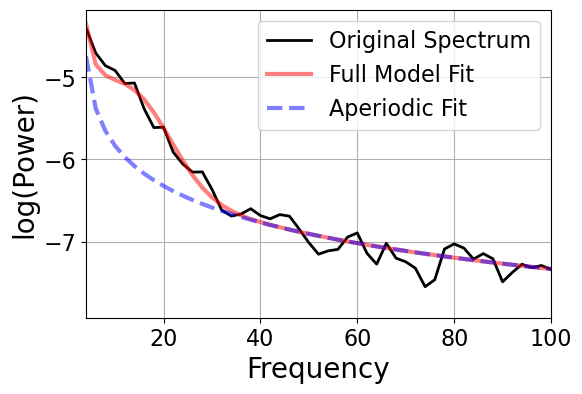

In [ ]:
tseg = 0.5 # second
time_window = (500., 3000.)
f, pxx = ss.welch(lfps.sel(channel_id=3, time=slice(*time_window)), fs=lfps.fs, nperseg=int(tseg * lfps.fs))
plot.fit_fooof(f, pxx, aperiodic_mode='knee', plt_range=100., freq_range=200., plot=True, report=True, figsize=(6, 4))
plt.show()

In [ ]:
spike_file = "spike_rate.h5"

with h5py.File(os.path.join(trial_dir, spike_file), 'r') as f:
    pop_rspk = xr.DataArray(
        np.stack([g['data'] for g in f['populations'].values()], axis=0),
        coords = dict(
            population = list(f['populations'].keys()),
            time = np.arange(*f['time'])
        ),
        attrs = dict(
            fs = 1000 / f['time'][2]
        )
    ).to_dataset(name='spike_rate', promote_attrs=True)
    pop_rspk = pop_rspk.assign(
        population_number = xr.DataArray(
            [g.attrs['number'] for g in f['populations'].values()],
            coords = dict(
                population = pop_rspk.coords['population']
            )
        )
    )
display(pop_rspk)

<xarray.Dataset>
Dimensions:            (population: 34, time: 6000)
Coordinates:
  * population         (population) <U11 'LIFe23' 'LIFe4' ... 'i6Pvalb' 'i6Sst'
  * time               (time) float64 0.0 0.5 1.0 ... 2.998e+03 2.999e+03 3e+03
Data variables:
    spike_rate         (population, time) int64 0 0 0 0 0 0 0 ... 1 2 1 2 1 1 1
    population_number  (population) int64 43368 35507 25989 ... 192 1052 1059
Attributes:
    fs:       2000.0